<a href="https://colab.research.google.com/github/XBennyX2/simple_express/blob/master/PCA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SKPCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(style="whitegrid")



In [ ]:
# User settings
CSV_PATH = "/content/Wine.csv"   # path where you uploaded the CSV
TARGET_COL = "Customer_Segment"  # target column in your dataset
VAR_THRESHOLD = 0.95            # cumulative explained variance threshold for automatic selection
TRIALS = 20                     # number of repeated train/test splits for robust ML comparison
TEST_SIZE = 0.30
RANDOM_SEED = 42

ADD_NOISY_FEATURES = True
NOISY_FEATURE_COUNT = 100  # number of synthetic noise features to append if ADD_NOISY_FEATURES = True


## Load Dataset

In [ ]:
try:
    wine_df = pd.read_csv(CSV_PATH)
except Exception as e:
    raise FileNotFoundError(f"Could not read {CSV_PATH}. Upload wine.csv to Colab or set CSV_PATH correctly. Original error: {e}")

display(wine_df.head())

# verify target column exists
if TARGET_COL not in wine_df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in dataset. Available columns: {list(wine_df.columns)}")

# separate features and target
X_df = wine_df.drop(columns=[TARGET_COL])
y = wine_df[TARGET_COL].values

if ADD_NOISY_FEATURES:
    rng = np.random.RandomState(RANDOM_SEED)
    noise = rng.normal(loc=0.0, scale=1.0, size=(X_df.shape[0], NOISY_FEATURE_COUNT))
    noise_cols = [f"noise_{i}" for i in range(NOISY_FEATURE_COUNT)]
    X_df = pd.concat([X_df.reset_index(drop=True), pd.DataFrame(noise, columns=noise_cols)], axis=1)
    display(Markdown(f"⚠️ Added {NOISY_FEATURE_COUNT} noisy features to emphasize PCA benefit"))


,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


⚠️ Added 100 noisy features to emphasize PCA benefit

In [ ]:
scaler_full = StandardScaler()
X_std_full = scaler_full.fit_transform(X_df)
print("Standardized features sample mean (first 5):", np.round(X_std_full.mean(axis=0)[:5], 4))
print("Standardized features sample std  (first 5):", np.round(X_std_full.std(axis=0, ddof=0)[:5], 4))

Standardized features sample mean (first 5): [-0. -0. -0. -0. -0.]
Standardized features sample std  (first 5): [1. 1. 1. 1. 1.]


In [ ]:
cov_full = np.cov(X_std_full.T)
print("Covariance matrix shape:", cov_full.shape)

Covariance matrix shape: (113, 113)


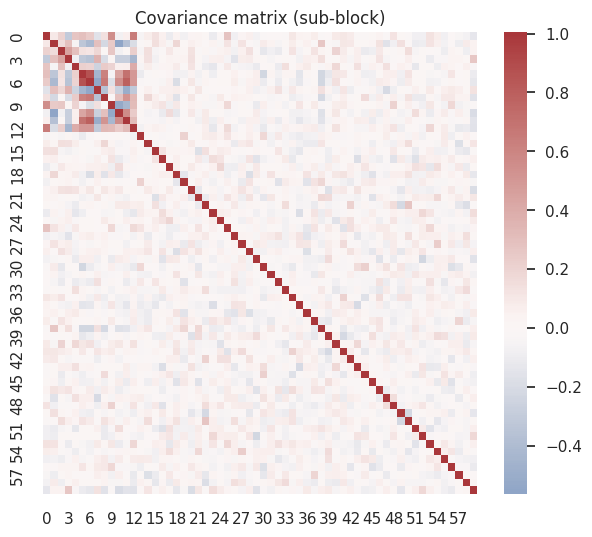

In [ ]:
n_show = min(60, cov_full.shape[0])
plt.figure(figsize=(7,6))
sns.heatmap(cov_full[:n_show, :n_show], cmap="vlag", center=0)
plt.title("Covariance matrix (sub-block)")
plt.show()

In [ ]:
eigvals_all, eigvecs_all = np.linalg.eigh(cov_full)  # ascending eigenvalues
# sort descending
idx_desc = np.argsort(eigvals_all)[::-1]
eigvals_sorted = eigvals_all[idx_desc].real
eigvecs_sorted = eigvecs_all[:, idx_desc].real

display(Markdown("Top 8 eigenvalues (λ):"))
for i in range(min(8, eigvals_sorted.shape[0])):
    print(f"λ_{i+1} = {eigvals_sorted[i]:.6f}")
total_variance = np.sum(eigvals_sorted)
display(Markdown(f"Total variance (sum of eigenvalues) = {total_variance:.6f}"))

Top 8 eigenvalues (λ):

λ_1 = 5.279266
λ_2 = 3.453214
λ_3 = 2.966993
λ_4 = 2.865755
λ_5 = 2.704091
λ_6 = 2.572032
λ_7 = 2.496217
λ_8 = 2.461243


Total variance (sum of eigenvalues) = 113.638418

## 5. Explained Variance Ratio & Cumulative Explained Variance

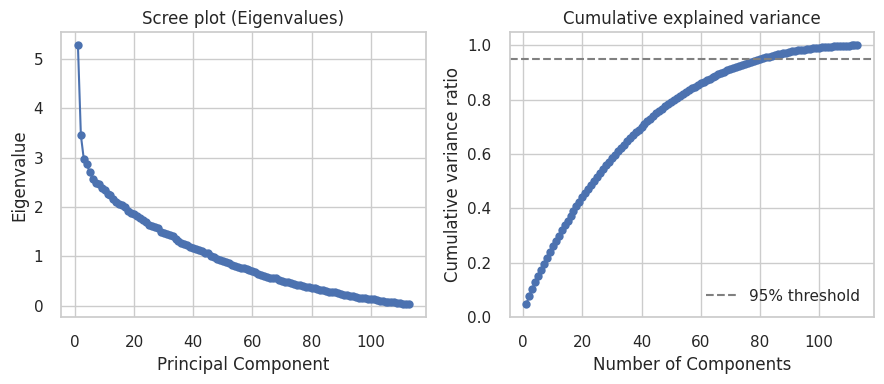

In [ ]:
display(Markdown("## 5. Explained Variance Ratio & Cumulative Explained Variance"))
explained_variance_ratio = eigvals_sorted / total_variance
cumulative = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(np.arange(1, len(eigvals_sorted)+1), eigvals_sorted, marker='o')
plt.title("Scree plot (Eigenvalues)")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(np.arange(1, len(cumulative)+1), cumulative, marker='o')
plt.axhline(VAR_THRESHOLD, color='gray', linestyle='--', label=f"{int(VAR_THRESHOLD*100)}% threshold")
plt.title("Cumulative explained variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative variance ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
k_global = int(np.searchsorted(cumulative, VAR_THRESHOLD) + 1)
display(Markdown(f"**Global automatic selection (≥ {int(VAR_THRESHOLD*100)}% variance)** → k = {k_global}"))
# Kaiser criterion
kaiser_count = np.sum(eigvals_sorted > 1.0)
display(Markdown(f"Kaiser criterion (eigenvalue > 1) suggests keeping {kaiser_count} components (auxiliary check)"))

**Global automatic selection (≥ 95% variance)** → k = 81

Kaiser criterion (eigenvalue > 1) suggests keeping 46 components (auxiliary check)

In [ ]:
display(Markdown("## 6. Feature contributions (loadings)\nLoadings = eigenvectors * sqrt(eigenvalue) (magnitude of feature influence on each PC)"))
num_show = min(3, eigvecs_sorted.shape[1])
loadings = eigvecs_sorted[:, :num_show] * np.sqrt(eigvals_sorted[:num_show])
feature_names = X_df.columns.tolist()
for pc in range(num_show):
    pc_load = loadings[:, pc]
    top_idx = np.argsort(np.abs(pc_load))[::-1][:8]
    display(Markdown(f"Top contributors for PC{pc+1}:"))
    for fi in top_idx:
        print(f"  {feature_names[fi]:30s}: {pc_load[fi]:+.6f}")
    print("")

## 6. Feature contributions (loadings)
Loadings = eigenvectors * sqrt(eigenvalue) (magnitude of feature influence on each PC)

Top contributors for PC1:

  Flavanoids                    : +0.913451
  Total_Phenols                 : +0.849054
  OD280                         : +0.799706
  Proanthocyanins               : +0.685967
  Hue                           : +0.638186
  Nonflavanoid_Phenols          : -0.627487
  Proline                       : +0.602980
  Malic_Acid                    : -0.537206



Top contributors for PC2:

  Color_Intensity               : +0.714431
  Alcohol                       : +0.662478
  Proline                       : +0.542717
  Ash                           : +0.479166
  Magnesium                     : +0.399476
  Malic_Acid                    : +0.387551
  Hue                           : -0.384148
  noise_68                      : -0.340747



Top contributors for PC3:

  noise_76                      : +0.422482
  noise_66                      : +0.414792
  noise_29                      : +0.372219
  noise_14                      : -0.351256
  noise_91                      : +0.341091
  noise_81                      : +0.308617
  noise_63                      : -0.308185
  noise_9                       : +0.304996



## 7. Project data onto PCs (manual projection) — 2D & 3D visualizations

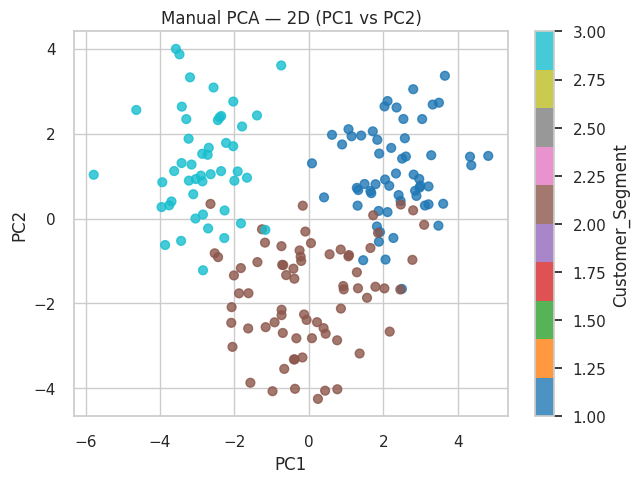

In [ ]:
display(Markdown("## 7. Project data onto PCs (manual projection) — 2D & 3D visualizations"))
W2 = eigvecs_sorted[:, :2]
W3 = eigvecs_sorted[:, :3]
X_pca2 = X_std_full @ W2
X_pca3 = X_std_full @ W3

plt.figure(figsize=(7,5))
scatter = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, cmap='tab10', s=40, alpha=0.8)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Manual PCA — 2D (PC1 vs PC2)")
plt.colorbar(scatter, label='Customer_Segment')
plt.show()

# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2], c=y, cmap='tab10', s=30, alpha=0.8)
# ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
# ax.set_title("Manual PCA — 3D (PC1,PC2,PC3)")
# plt.show()

## 8. sklearn PCA

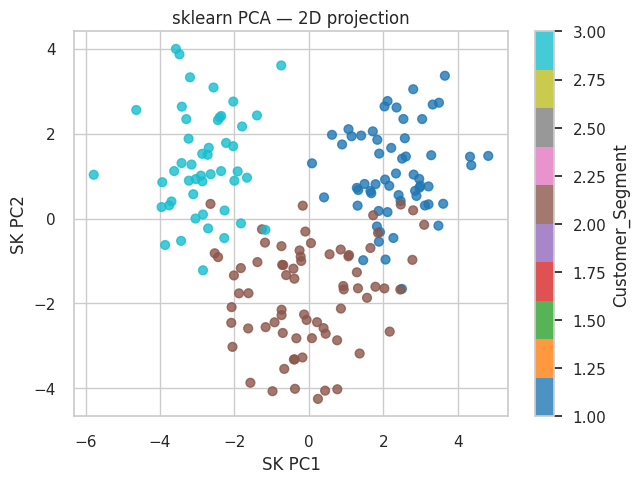

Note: sklearn PCA (SVD) and manual PCA (eigen decomposition) are equivalent up to sign flips.

In [ ]:
display(Markdown("## 8. sklearn PCA"))
sk_pca2 = SKPCA(n_components=2, random_state=RANDOM_SEED)
X_sk2 = sk_pca2.fit_transform(X_std_full)
plt.figure(figsize=(7,5))
plt.scatter(X_sk2[:,0], X_sk2[:,1], c=y, cmap='tab10', s=40, alpha=0.8)
plt.xlabel("SK PC1"); plt.ylabel("SK PC2"); plt.title("sklearn PCA — 2D projection")
plt.colorbar(label='Customer_Segment')
plt.show()
display(Markdown("Note: sklearn PCA (SVD) and manual PCA (eigen decomposition) are equivalent up to sign flips."))

##  ML Application — Proper evaluation (PCA fitted on training only inside each split)

In [ ]:

def eval_proper_pca(X_full, y_full, var_threshold=VAR_THRESHOLD, trials=TRIALS, test_size=TEST_SIZE, random_seed=RANDOM_SEED):
    acc_no = []
    acc_pca = []
    ks = []  # chosen k per fold
    for t in range(trials):
        seed = random_seed + t
        Xtr, Xte, ytr, yte = train_test_split(X_full, y_full, test_size=test_size, stratify=y_full, random_state=seed)
        # standardize on train
        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr)
        Xte_s = scaler.transform(Xte)
        # covariance on train
        cov_tr = np.cov(Xtr_s.T)
        eigvals_tr, eigvecs_tr = np.linalg.eigh(cov_tr)
        idx_tr = np.argsort(eigvals_tr)[::-1]
        eigvals_tr_s = eigvals_tr[idx_tr].real
        eigvecs_tr_s = eigvecs_tr[:, idx_tr].real
        # choose k by cumulative on train
        cum_tr = np.cumsum(eigvals_tr_s) / np.sum(eigvals_tr_s)
        k_tr = int(np.searchsorted(cum_tr, var_threshold) + 1)
        ks.append(k_tr)
        # project
        W_tr = eigvecs_tr_s[:, :k_tr]
        Xtr_p = Xtr_s @ W_tr
        Xte_p = Xte_s @ W_tr
        # classifiers
        clf_no = LogisticRegression(max_iter=1000, random_state=seed)
        clf_no.fit(Xtr_s, ytr)
        pred_no = clf_no.predict(Xte_s)
        acc_no.append(accuracy_score(yte, pred_no))
        clf_p = LogisticRegression(max_iter=1000, random_state=seed)
        clf_p.fit(Xtr_p, ytr)
        pred_p = clf_p.predict(Xte_p)
        acc_pca.append(accuracy_score(yte, pred_p))
    return np.array(acc_no), np.array(acc_pca), np.array(ks)

### Results (mean ± std over repeated splits)

WITHOUT PCA: mean = 0.9194, std = 0.0306
WITH PCA   : mean = 0.9231, std = 0.0311


Average chosen k per fold = 71 (std 0.5)

/tmp/ipython-input-324684769.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accs_no, accs_pca], labels=["No PCA", "PCA (train-fit)"], showmeans=True)


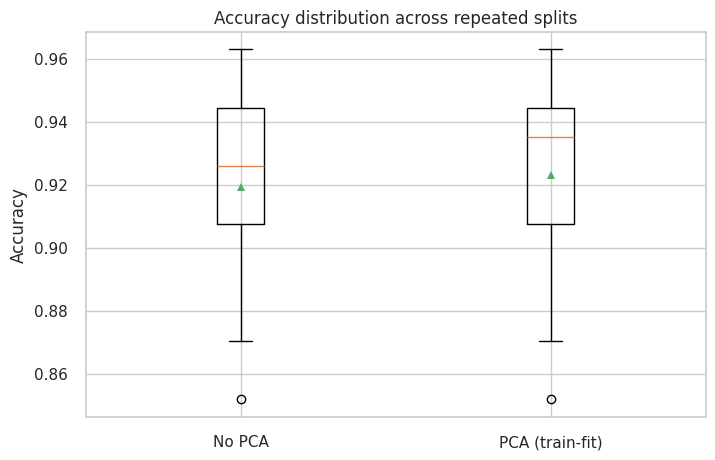

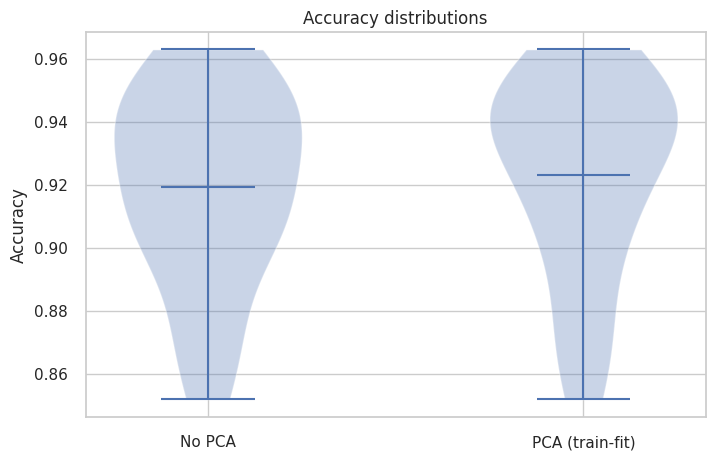

✅ PCA improved mean accuracy: 0.9194 → 0.9231

## 10. Reconstruction (global k) demonstration

Reconstruction MSE using global k=81: 0.047456

In [ ]:

accs_no, accs_pca, ks = eval_proper_pca(X_std_full, y, var_threshold=VAR_THRESHOLD, trials=TRIALS)

display(Markdown("### Results (mean ± std over repeated splits)"))
print("WITHOUT PCA: mean = {:.4f}, std = {:.4f}".format(accs_no.mean(), accs_no.std()))
print("WITH PCA   : mean = {:.4f}, std = {:.4f}".format(accs_pca.mean(), accs_pca.std()))
display(Markdown(f"Average chosen k per fold = {int(np.round(np.mean(ks)))} (std {np.round(np.std(ks),1)})"))

# show boxplots
plt.figure(figsize=(8,5))
plt.boxplot([accs_no, accs_pca], labels=["No PCA", "PCA (train-fit)"], showmeans=True)
plt.ylabel("Accuracy")
plt.title("Accuracy distribution across repeated splits")
plt.grid(True)
plt.show()

# show violin plot for clarity
plt.figure(figsize=(8,5))
plt.violinplot([accs_no, accs_pca], showmeans=True)
plt.xticks([1,2], ["No PCA", "PCA (train-fit)"])
plt.ylabel("Accuracy")
plt.title("Accuracy distributions")
plt.grid(True)
plt.show()

if accs_pca.mean() > accs_no.mean():
    display(Markdown(f"✅ PCA improved mean accuracy: {accs_no.mean():.4f} → {accs_pca.mean():.4f}"))
else:
    display(Markdown(f"⚠️ PCA did NOT improve mean accuracy in these runs: {accs_no.mean():.4f} → {accs_pca.mean():.4f}.\n"
                     "Consider enabling ADD_NOISY_FEATURES=True to add synthetic irrelevant features, which often makes the denoising benefit of PCA clearer."))




In [ ]:
# ------------------------------
# 10) Reconstruction MSE using global k (demonstration)
# ------------------------------
display(Markdown("## 10. Reconstruction (global k) demonstration"))
W_global_k = eigvecs_sorted[:, :k_global]
X_proj_k = X_std_full @ W_global_k
X_recon = X_proj_k @ W_global_k.T
recon_mse = np.mean((X_std_full - X_recon) ** 2)
display(Markdown(f"Reconstruction MSE using global k={k_global}: {recon_mse:.6f}"))